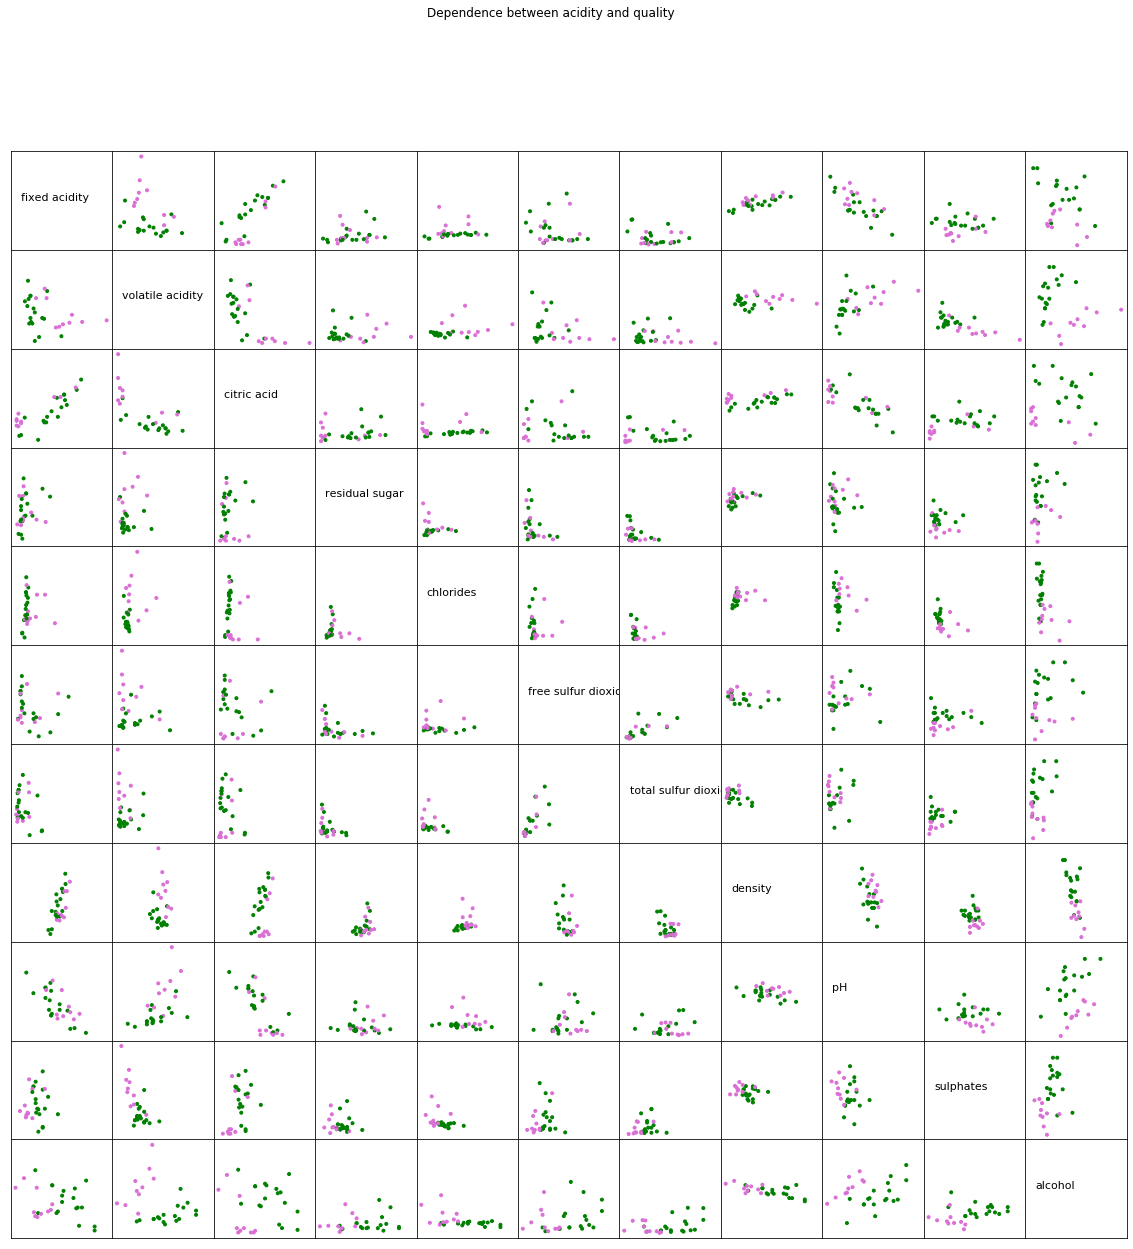

In [2]:
#V.1

import matplotlib.pyplot as plt
import pandas as pd

# You are allowed to import and use the matplotlib, pandas, and the standard python libraries for this project.
# ◦ You are NOT allowed to use pandas DataFrame math/matrix methods (i.e.
# ‘.T’, ‘.transpose’, ‘.dot’, ‘.add’, ‘.divide’, ‘.mean’, ‘.std’, etc. . . )
# • You are NOT allowed to directly import and use libraries like: numpy, scipy, scikitlearn, tensorflow, etc

white_df = pd.read_csv("resources/winequality-white.csv", sep=";")
red_df = pd.read_csv("resources/winequality-red.csv", sep=";") 

def plot_scatter_matrix(wine_data: pd.DataFrame, good_threshold: int, bad_threshold: int, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    this function will produce graphs which shows dependence between
    every two factors.
    """
    assert good_threshold > bad_threshold, "Please, enter good_treshold sctrictly > than bad_treshold"
    q = wine_data['quality']    

    labels = wine_data.columns[:-1]
    assert len(labels) >=2, "there have to be at least 2 labels ti build dependence"
    f, axarr = plt.subplots(len(labels), len(labels), figsize=(20, 20))
    f.suptitle('Dependence between acidity and quality')
    f.subplots_adjust(wspace=0, hspace=0)

    k = 0
    for x in [wine_data[label] for label in labels]:
        j = 0
        for y in [wine_data[label] for label in labels]:
            axarr[k][j].set_xticks([])
            axarr[k][j].set_yticks([])
            if k == j:
                axarr[k][j].text(0.1, 0.5, labels[k], fontsize=11)
            else:
                colors = [('orchid' if q[i]<= bad_threshold else ('green' if q[i]>=good_threshold else 'None'))\
                          for i in range(wine_data.shape[0])]
                axarr[k][j].scatter(x, y, marker='.', c=colors)
            j+=1
        k+=1
    plt.savefig('fig.png') if save_plot else 0
    return
        
    
plot_scatter_matrix(red_df, 8, 3, False)
# plot_scatter_matrix(white_df, 7, 4)

# Important chemical factors: volatile acidity, sulfates, alcohol. 
# Basically we can divide almost strictly bad and good wines considering them.

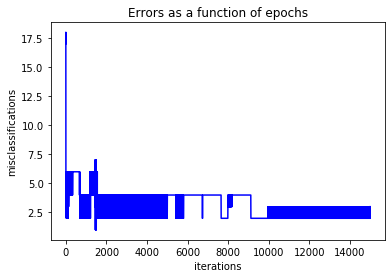

(threshold - b)/w2 = 0.3663146983588675, w1 = -11.584668858425754, w2 = 3.3847015899523702, b = 6.760134058041818


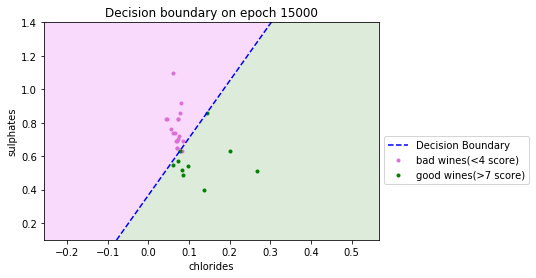

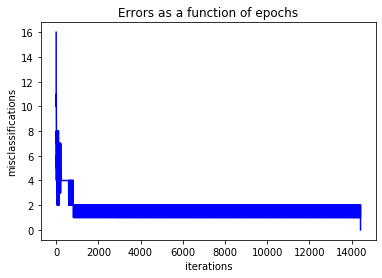

(threshold - b)/w2 = -3.5418873505721495, w1 = -72.65713120430812, w2 = 17.332056050679522, b = 69.38819008530929


In [ ]:
# V.2
#             import pdb; pdb.set_trace()

import random
random.seed(1777)


def dot(a: list, b: list) -> float:
    """
    Scalar product of 2 vectors a and b
    """
    assert len(a) == len(b), "Vectors must be equal length!"
    return sum([a[i] * b[i] for i in range(len(a))])

class Perceptron(object):

    def __init__(self, threshold, learning_rate =0.01, epochs=0):
        self.learning_rate = learning_rate
        self.epochs = epochs 
        self.res = []
        self.current_epoch = 0
        self.threshold = threshold
        return

    def error(self, y: list, d: list) -> int:
        return sum(abs(d-y))

    def do_step(self, x, y, d):
        for row in range(len(x)):
            y[row] = int(dot(x[row], self.w) + self.bias >= self.threshold)
            for col in range(len(x[row])):
                self.w[col] += self.learning_rate * (d[row] - y[row]) * x[row][col]
            self.bias += self.learning_rate * (d[row] - y[row])
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        return

    def train(self, x: list, d: list): 
        """
        train perceptron on received data
        x - received data (matrix, row - one specific wine)
        d - desired output (good(1) or bad(0) wines good=(quality>threshold))
        """
        assert (len(x) == len(d)), "x should have the same amount of rows as d"
        self.w = [random.random() for i in range(len(x[0]))] # x1w1 + x2w2 + b. 
        self.bias = random.random()
        y = [int(random.random() > 0.5) for _ in range(len(x))]
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        if self.epochs > 0:
            for _ in range(self.epochs):
                self.do_step(x, y, d)
        else:
            while self.res[-1][1] > 0:
                self.do_step(x, y, d)
        return


def plot_performance(performance, wine_data, good_thresh, bad_thresh, factors: list, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    this function will produce a two plot figure:
    1) Classification Errors vs. Epochs
    2) Decision boundary for two factors
    """
    if epoch < 0 or epoch > performance[-1][0]:
        print(f'epoch was : {epoch}')
        epoch = performance[-1][0]
    plt.figure(1)
    errors = [performance[i][1]  for i in range(len(performance))]
    epochs = [performance[i][0]  for i in range(len(performance))]
    plt.plot(epochs, errors, c='b')
    plt.xlabel('iterations')
    plt.ylabel('misclassifications')
    plt.title('Errors as a function of epochs')
    plt.show()

    b = performance[epoch][3]
    w1 = performance[epoch][2][0]
    w2 = performance[epoch][2][1]
    assert w2 != 0, "w2 = 0"
    print(f'(threshold - b)/w2 = {(good_thresh-b)/w2}, w1 = {w1}, w2 = {w2}, b = {b}') # x1w1 + x2w2 + b =8
    f1 = [i for i in range(-50, 50)]
    f2 = [ (good_thresh -b - w1 * f1[j]) / w2 for j in range(len(f1))]
    plt.figure(2)
    plt.xlim(min(wine_data[factors[0]].values)-0.3, max(wine_data[factors[0]].values)+0.3)
    plt.ylim(min(wine_data[factors[1]].values)-0.3, max(wine_data[factors[1]].values)+0.3)
    plt.plot(f1, f2, linestyle='--', color='b', label='Decision Boundary')
   
    goods = wine_data[wine_data['quality'] >= good_thresh]
    bads = wine_data[wine_data['quality'] <= bad_thresh]
    xg = goods[factors[0]].values
    yg = goods[factors[1]].values
    xb = bads[factors[0]].values
    yb = bads[factors[1]].values

    
    # count good dots and define how to fill the field
    right_color, left_color = (0.976, 0.854, 0.992), (0.866, 0.921, 0.854)
    righter = 0
    for xi, yi in zip(xg, yg):
        if (good_thresh - b - w1 * xi) / w2 < yi:
            righter += 1
    if righter > len(xg) / 2:
        right_color, left_color = (0.866, 0.921, 0.854), (0.976, 0.854, 0.992)
    

    plt.fill_between(f1, f2, 100, facecolor=left_color)
    plt.fill_between(f1, f2, -100, facecolor=right_color)
    plt.scatter(xg, yg, marker='.', c='orchid', label=f'bad wines(<{bad_thresh+1} score)')
    plt.scatter(xb, yb, marker='.', c='green', label=f'good wines(>{good_thresh-1} score)')
    plt.title(f'Decision boundary on epoch {epoch}')
    plt.xlabel(factors[0]) 
    plt.ylabel(factors[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    return

import imageio
def prepare_data_and_train(wine_data: pd.DataFrame, factors: list, wines_threshs: list, epochs: int):
    learning_rate = 0.1
    threshold = 8
    perceptron = Perceptron(threshold, learning_rate, epochs)
    part = wine_data[wine_data.quality.isin(wines_threshs)]
    part.index = range(len(part))
    x = part[factors].values
    d = (part['quality'] >= threshold).astype(int)
    perceptron.train(x, d)
    plot_performance(perceptron.res, part, wines_threshs[1], wines_threshs[0], factors, perceptron.current_epoch)
    return


prepare_data_and_train(red_df, ['chlorides', 'sulphates'], [3, 8], 15000)
prepare_data_and_train(red_df, ['pH', 'alcohol'], [3, 8], 0)
prepare_data_and_train(red_df, ['volatile acidity', 'alcohol'], [3, 8], 15000)
prepare_data_and_train(red_df, ['density', 'volatile acidity'], [3, 8], 15000)

# V.2 end

In [ ]:
# V.3

# Delta Learning Rule (Widrow-Hoff Rule)
# It is introduced by Bernard Widrow and Marcian Hoff, also called Least Mean Square (LMS) method, 
# to minimize the error over all training patterns. It is kind of supervised learning algorithm with 
# having continuous activation function.
# https://www.tutorialspoint.com/artificial_neural_network/artificial_neural_network_learning_adaptation.htm


# Have an option to perform either online learning or batch learning
class Adaline(object):

    def __init__(self, threshold, learning_rate=0.01, epochs=0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.res = []
        self.current_epoch = 0
        self.threshold = threshold
        return

    def error(self, y: list, d: list) -> float:
        r = 0
        for i in range(len(d)):
            r += (d[i] - y[i]) * (d[i] - y[i])
        return round(r, 4) # ##############

    def do_step(self, x, y, d):
        for row in range(len(x)):
            y[row] = dot(x[row], self.w) + self.bias
            for col in range(len(x[row])):
                update = self.learning_rate * (d[row] - y[row]) * x[row][col]
                self.w[col] += update
            self.bias += self.learning_rate * (d[row] - y[row])
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, y])
        return
          
    def train(self, x: list, d: list):
        """
        train adaline on received data
        x - received data (matrix, row - one specific wine)
        d - desired output
        """
        assert (len(x) == len(d)), "x should have the same amount of rows as d"
        self.w = [random.random() for i in range(len(x[0]))]
        self.bias = random.random()
        y = [random.random() for _ in range(len(x))]
        self.res.append([self.current_epoch, self.error(y, d), self.w, y])
        if self.epochs > 0:
            for _ in range(self.epochs):
                self.do_step(x, y, d)
        else:
            while self.res[-1][1] > 0:
                self.do_step(x, y, d)
        return


def prepare_data_and_train_ada(wine_data: pd.DataFrame, factors: list, wines_threshs: list, epochs: int):
    learning_rate = 0.001
    threshold = 8
    ada = Adaline(threshold, learning_rate, epochs)
    part = wine_data[wine_data.quality.isin(wines_threshs)]
    part.index = range(len(part))
    x = part[factors].values
    d = part['quality']
#     import pdb; pdb.set_trace()
    ada.train(x, d)
    plot_performance(ada.res, part, wines_threshs[1], wines_threshs[0], factors, ada.current_epoch)
    return

prepare_data_and_train_ada(red_df, ['alcohol', 'pH'], [3, 8], 1000)
prepare_data_and_train_ada(red_df, ['alcohol', 'pH'], [3, 8], 15000)